In [1]:
# CELL 0 — Install Required Packages
!pip install imbalanced-learn
!pip install shap
!pip install xgboost  # optional but recommended for students who want to try it
!pip install lightgbm  # optional (if GPU available)

You should consider upgrading via the 'C:\Users\anasn\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\anasn\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
ERROR: Invalid requirement: '#'
You should consider upgrading via the 'C:\Users\anasn\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
ERROR: Invalid requirement: '#'
You should consider upgrading via the 'C:\Users\anasn\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from kneed import KneeLocator

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

C:\Users\anasn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the Titanic Dataset

In [2]:
data_path = "sampled_data.csv"
data = pd.read_csv(data_path)

# 2 — Data Understanding
We will:
- Inspect the target distribution  
- Look at missing values  
- Visualize numeric features  
- Explore basic relationships with survival  
- Check correlations between numeric variables


In [3]:
data.shape

(2208, 5)

In [4]:
data.head(5)

,fibrin_red,granulation_green,callus_blue,background,Cluster_Hierarchical
0,0.002549,0.098765,0.247379,0.689636,2
1,0.003823,0.098961,0.112071,0.820562,3
2,0.000319,0.287870,0.076509,0.723815,4
3,0.005734,0.041152,0.482290,0.500276,1
4,0.000000,0.180090,0.059507,0.816290,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fibrin_red            2208 non-null   float64
 1   granulation_green     2208 non-null   float64
 2   callus_blue           2208 non-null   float64
 3   background            2208 non-null   float64
 4   Cluster_Hierarchical  2208 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 86.4 KB


In [6]:
data.isnull().sum()

fibrin_red              0
granulation_green       0
callus_blue             0
background              0
Cluster_Hierarchical    0
dtype: int64

In [7]:
for col in data.columns:
    print(f"\n Colonne : {col}")
    print(data[col].unique())



 Colonne : fibrin_red
[2.54858235e-03 3.82287353e-03 3.18572794e-04 5.73431029e-03
 0.00000000e+00 3.16979930e-01 1.27429118e-03 1.02899012e-01
 1.87957948e-02 1.72029309e-02 8.92003823e-03 6.37145588e-03
 1.10226187e-01 1.91143676e-03 4.30073272e-02 8.76075183e-02
 9.87575661e-03 2.86715514e-03 2.16629500e-02 1.40172029e-02
 2.62503982e-01 9.23861102e-03 5.57502389e-02 1.22331953e-01
 6.37145588e-04 1.81586493e-02 6.18031220e-02 3.75915897e-02
 1.00987576e-01 6.14845492e-02 2.22363810e-01 1.78400765e-02
 3.72730169e-02 4.46001911e-03 4.05543167e-01 8.18732080e-02
 2.35743867e-02 1.52914941e-02 6.08474036e-02 1.36986301e-02
 7.96431985e-03 3.59987257e-02 7.64574705e-03 1.43357757e-02
 3.36412870e-01 2.41796751e-01 7.32717426e-03 6.97674419e-02
 3.50430073e-03 1.47817776e-01 1.00669003e-01 3.63172985e-02
 2.03886588e-02 3.43102899e-01 8.82446639e-02 9.55718382e-04
 5.66103855e-01 5.60688117e-02 1.59286397e-03 4.43771902e-01
 4.36444728e-02 6.62631411e-02 6.81745779e-02 5.09716470e-03
 

In [10]:
nbr_doublons= data.duplicated().sum()
nbr_doublons

0

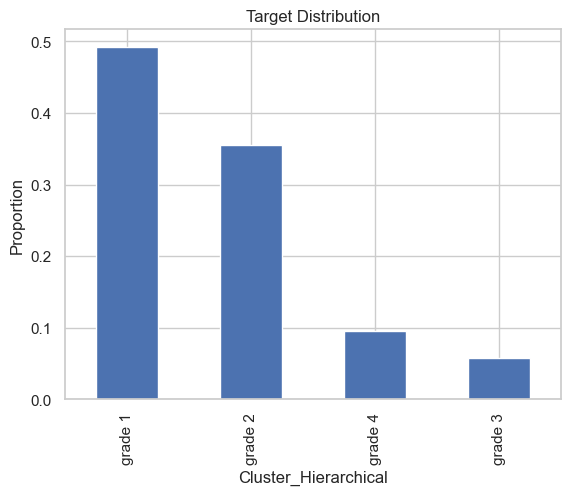

Cluster_Hierarchical
grade 1    0.492147
grade 2    0.354593
grade 4    0.095193
grade 3    0.058068
Name: proportion, dtype: float64

In [12]:
data["Cluster_Hierarchical"].value_counts(normalize=True).plot(kind="bar")
plt.title("Target Distribution")
plt.ylabel("Proportion")
plt.show()

data["Cluster_Hierarchical"].value_counts(normalize=True)

In [11]:
import pandas as pd

# Exemple : ta DataFrame s'appelle sampled_data
# 1. Créer un dictionnaire de mapping
mapping = {
    2: "grade 1",
    3: "grade 2",
    5: "grade 3",
    4: "grade 4"
}

# 2. Remplacer les valeurs selon le mapping
data["Cluster_Hierarchical"] = data["Cluster_Hierarchical"].map(mapping)

# 3. Supprimer les lignes où Cluster_Hierarchical était 1 (donc devient NaN après map)
data = data.dropna(subset=["Cluster_Hierarchical"])

# Vérification
print(data["Cluster_Hierarchical"].value_counts())

Cluster_Hierarchical
grade 1    1034
grade 2     745
grade 4     200
grade 3     122
Name: count, dtype: int64


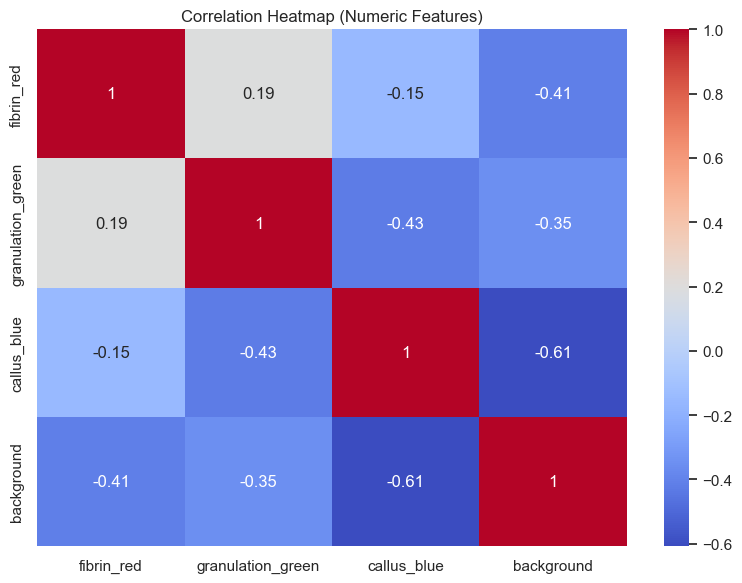

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

# 3 — Data Preparation 
## 3.1 — Data Cleaning

In [14]:
data.isnull().sum()

fibrin_red              0
granulation_green       0
callus_blue             0
background              0
Cluster_Hierarchical    0
dtype: int64

## 3.3 — Encoding

In [16]:
le = LabelEncoder()

In [17]:
for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col].astype(str))

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2101 entries, 0 to 2207
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fibrin_red            2101 non-null   float64
 1   granulation_green     2101 non-null   float64
 2   callus_blue           2101 non-null   float64
 3   background            2101 non-null   float64
 4   Cluster_Hierarchical  2101 non-null   int32  
dtypes: float64(4), int32(1)
memory usage: 90.3 KB


## 3.4 — Scaling 

In [20]:
scaled_df=data

In [27]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
scaled_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,TicketGroupSize
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.769118,0.014151,1.00000,1.0,0.1,0.0,0.000000
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.876471,0.139136,0.55102,0.0,0.1,0.0,0.000000
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.983824,0.015469,1.00000,1.0,0.0,1.0,0.000000
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.072059,0.103644,0.37415,1.0,0.1,0.0,0.166667
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.694118,0.015713,1.00000,1.0,0.0,1.0,0.000000


# 4 — Features Selection

## 4.1 — Correlation Heatmap

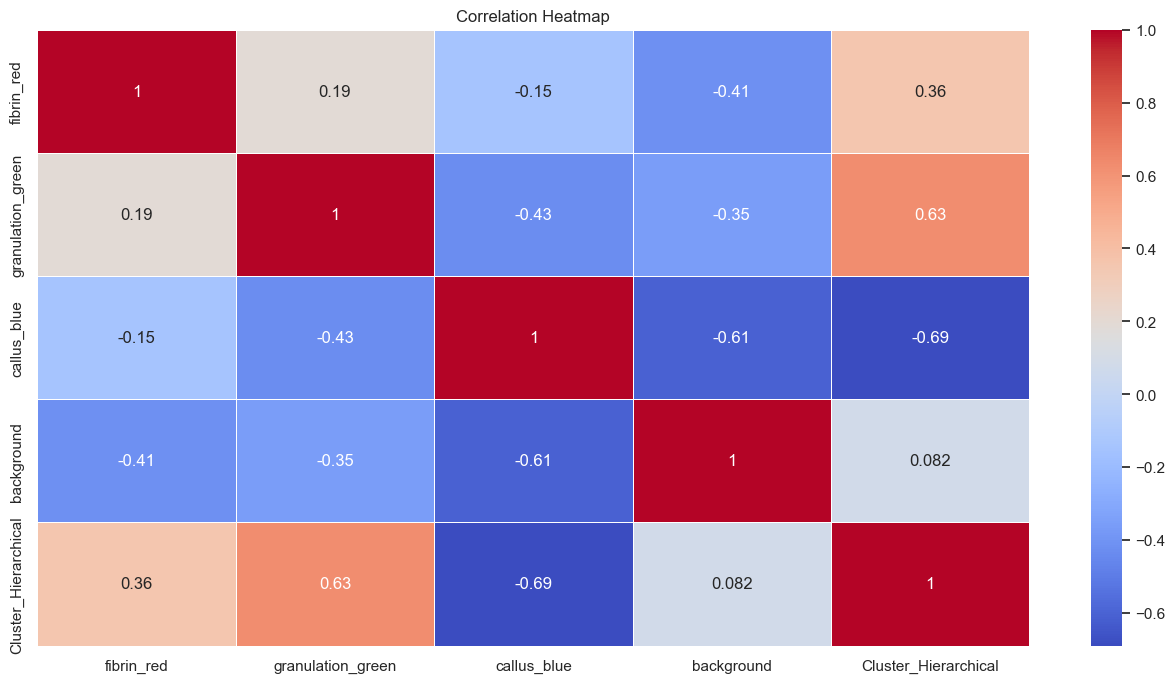

In [21]:
import seaborn as sns
correlation = scaled_df.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## 4.2 — KBest

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import pandas as pd

# Sélectionner les caractéristiques et la variable cible
X = scaled_df.drop(columns=['Cluster_Hierarchical'])  
y = scaled_df['Cluster_Hierarchical']  

# Appliquer SelectKBest
kbest = SelectKBest(score_func=f_regression, k='all')
kbest.fit(X, y)

# Récupérer les scores et les colonnes
scores = kbest.scores_
columns = X.columns

# Créer un DataFrame et trier par score décroissant
Kbest_scores = pd.DataFrame({'Feature': columns, 'Score': scores})
Kbest_scores = Kbest_scores.sort_values(by='Score', ascending=False)

# Afficher les résultats triés
Kbest_scores

,Feature,Score
2,callus_blue,1902.228502
1,granulation_green,1355.384017
0,fibrin_red,309.854832
3,background,14.315657


In [25]:
data_selected=scaled_df

In [30]:
selected_features = ['Sex', 'Pclass', 'Fare', 'Cabin', 'IsAlone','Embarked','Ticket','Survived']
data_selected = scaled_df[selected_features]
data_selected
data_selected.dtypes

Sex         float64
Pclass      float64
Fare        float64
Cabin       float64
IsAlone     float64
Embarked    float64
Ticket      float64
Survived    float64
dtype: object

# 5 — Train–Test Split

In [27]:
# Separate features and target
X = data_selected.drop('Cluster_Hierarchical', axis=1)
y = data_selected['Cluster_Hierarchical']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 6 — Data Balancing Using SMOTE

Cluster_Hierarchical
0    1034
1     745
3     200
2     122
Name: count, dtype: int64


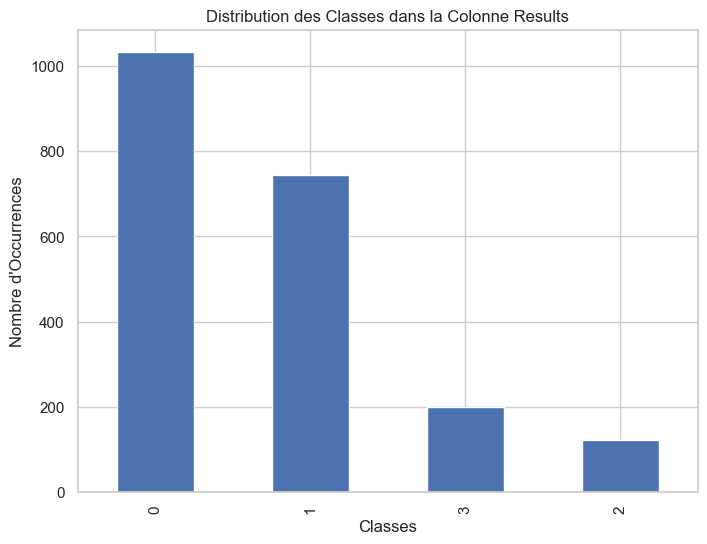

In [30]:
class_counts = data_selected['Cluster_Hierarchical'].value_counts()
print(class_counts)
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Distribution des Classes dans la Colonne Results')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'Occurrences')
plt.show()

In [29]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Original:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Original: Cluster_Hierarchical
0    827
1    596
3    160
2     97
Name: count, dtype: int64
After SMOTE: Cluster_Hierarchical
2    827
3    827
1    827
0    827
Name: count, dtype: int64


# 7 — Modeling

## 7.1 — KNN
Finding best hyperparam (k=?)

7.1.1 Elbow Method

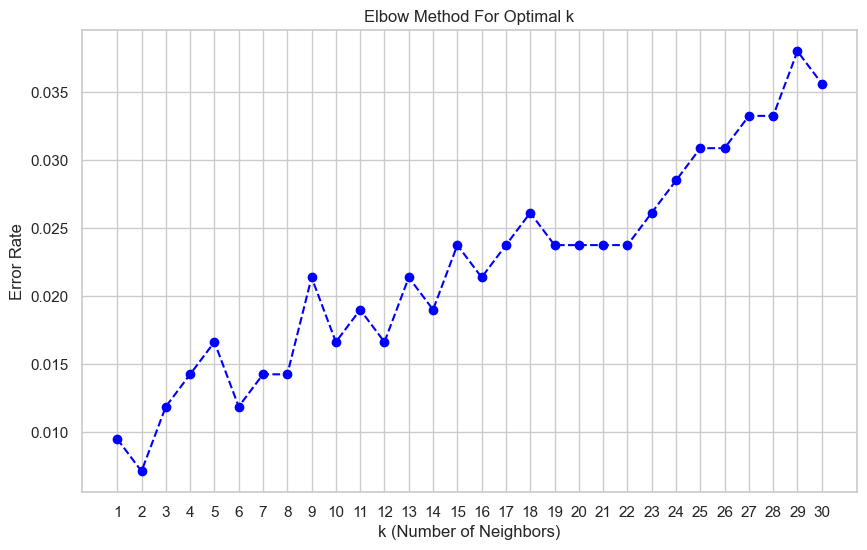

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from kneed import KneeLocator
import matplotlib.pyplot as plt

error_rates = []
k_values = list(range(1, 31))  # We'll test K from 1 to 30

# Loop through values of K and compute error rate (1 - accuracy)
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_res, y_train_res)
    y_pred_k = model.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred_k)
    error_rates.append(error)

# Plotting the elbow curve
plt.figure(figsize=(10,6))
plt.plot(k_values, error_rates, color='blue', linestyle='dashed', marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error Rate")
plt.xticks(k_values)
plt.grid(True)
plt.show()

7.1.2 KneeLocator

In [32]:
# Use KneeLocator to find the elbow point
kl = KneeLocator(k_values, error_rates, curve="convex", direction="decreasing")
best_k = kl.elbow
print(f"Optimal number of neighbors according to KneeLocator: {best_k}")

Optimal number of neighbors according to KneeLocator: 2


In [33]:
knn_opt = KNeighborsClassifier(n_neighbors=best_k)
knn_opt.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=2)

In [34]:
# Predictions
y_pred_opt = knn_opt.predict(X_test)
y_proba_opt = knn_opt.predict_proba(X_test)[:, 1]

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("📊 Performance with optimal k:")
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("F1 Score (macro):", f1_score(y_test, y_pred_opt, average="macro"))
print("Precision (macro):", precision_score(y_test, y_pred_opt, average="macro"))
print("Recall (macro):", recall_score(y_test, y_pred_opt, average="macro"))

📊 Performance with optimal k:
Accuracy: 0.9928741092636579
F1 Score (macro): 0.9865648599901797
Precision (macro): 0.9824567630356221
Recall (macro): 0.9908644181824077


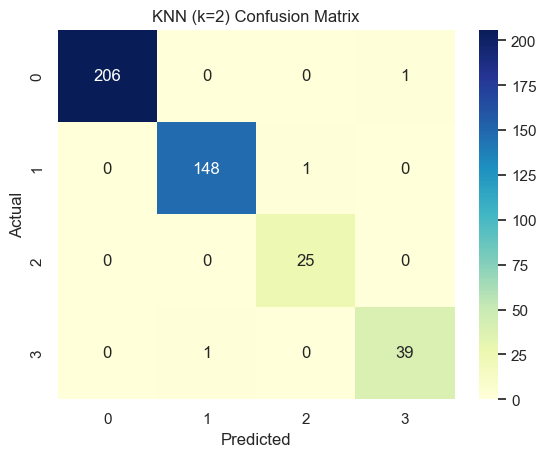

In [39]:
cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f"KNN (k={best_k}) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Store results for KNN
knn_results = {
    'Model': 'KNN',
    # 'k': best_k,
    'Accuracy': accuracy_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt, average="macro"),
    'Precision': precision_score(y_test, y_pred_opt, average="macro"),
    'Recall': recall_score(y_test, y_pred_opt, average="macro"),
}

# Create or update results DataFrame
results_df = pd.DataFrame([knn_results])
print(results_df)

  Model  Accuracy  F1 Score  Precision    Recall
0   KNN  0.992874  0.986565   0.982457  0.990864


## 7.2 — SVM

Best SVM parameters: C = 10.0 gamma = 10.0


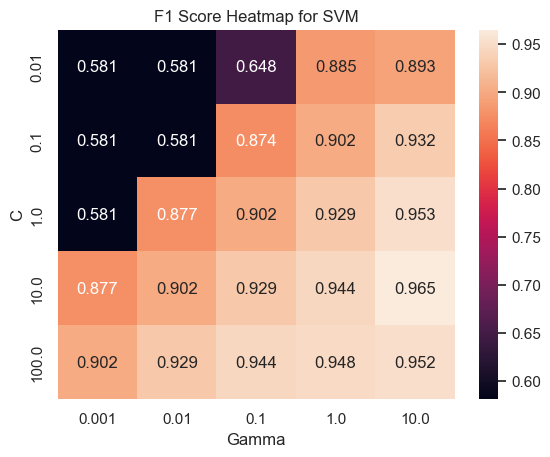

In [43]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

C_values = np.logspace(-2, 2, 5)
gamma_values = np.logspace(-3, 1, 5)
f1_scores_svm = np.zeros((len(C_values), len(gamma_values)))

for i, c in enumerate(C_values):
    for j, g in enumerate(gamma_values):
        model = SVC(C=c, gamma=g, kernel='rbf', probability=True, random_state=42)
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        # ⚠️ Ajout de average="macro" ou "weighted"
        f1_scores_svm[i, j] = f1_score(y_test, y_pred, average="macro")

best_idx = np.unravel_index(np.argmax(f1_scores_svm), f1_scores_svm.shape)
best_C = C_values[best_idx[0]]
best_gamma = gamma_values[best_idx[1]]

print("Best SVM parameters: C =", best_C, "gamma =", best_gamma)

# Heatmap
sns.heatmap(f1_scores_svm, xticklabels=gamma_values, yticklabels=C_values, annot=True, fmt=".3f")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('F1 Score Heatmap for SVM')
plt.show()

In [44]:
svm_final = SVC(C=best_C, gamma=best_gamma, probability=True, random_state=42)
svm_final.fit(X_train_res, y_train_res)

SVC(C=10.0, gamma=10.0, probability=True, random_state=42)

In [45]:
# Predictions
y_pred_svm_final = svm_final.predict(X_test)
y_proba_svm_final = svm_final.predict_proba(X_test)[:, 1]

In [46]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_svm_final))
print("F1 Score:", f1_score(y_test, y_pred_svm_final ,average="macro"))
print("Precision:", precision_score(y_test, y_pred_svm_final,average="macro"))
print("Recall:", recall_score(y_test, y_pred_svm_final,average="macro"))

Accuracy: 0.9762470308788599
F1 Score: 0.9651046243380977
Precision: 0.9546481812760883
Recall: 0.9764277956100249


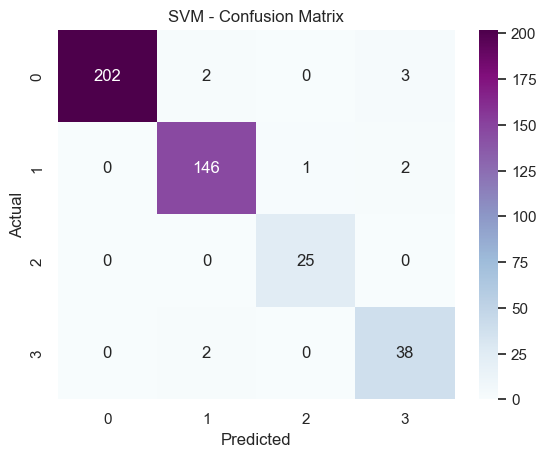

In [47]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm_final)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='BuPu')
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [48]:
svm_results = {
    'Model': 'SVM',
#     'C': best_C,
#     'Gamma': best_gamma,
    'Accuracy': accuracy_score(y_test, y_pred_svm_final),
    'F1 Score': f1_score(y_test, y_pred_svm_final,average="macro"),
    'Precision': precision_score(y_test, y_pred_svm_final,average="macro"),
    'Recall': recall_score(y_test, y_pred_svm_final,average="macro"),
}

# Append to results DataFrame (assume results_df already exists)
results_df = pd.concat([results_df, pd.DataFrame([svm_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428


## 7.3 — Logistic Regression

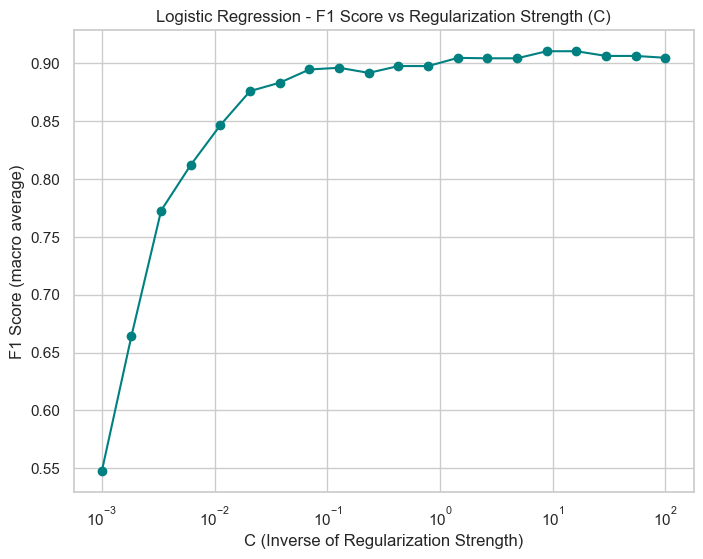

Best C value: 8.858667904100823


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

C_values = np.logspace(-3, 2, 20)
f1_scores = []

for c in C_values:
    model = LogisticRegression(C=c, solver='liblinear', random_state=42)
    model.fit(X_train_res, y_train_res)
    y_pred_c = model.predict(X_test)
    # ⚠️ Ajout de average="macro" ou "weighted"
    f1_scores.append(f1_score(y_test, y_pred_c, average="macro"))

# Plot the effect of C
plt.figure(figsize=(8,6))
plt.semilogx(C_values, f1_scores, marker='o', color='teal')
plt.title("Logistic Regression - F1 Score vs Regularization Strength (C)")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("F1 Score (macro average)")
plt.grid(True)
plt.show()

# Best C
best_C = C_values[np.argmax(f1_scores)]
print(f"Best C value: {best_C}")

In [51]:
logreg = LogisticRegression(C=best_C, solver='liblinear')
logreg.fit(X_train_res, y_train_res)

y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

In [53]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr,average="macro"))
print("Precision:", precision_score(y_test, y_pred_lr,average="macro"))
print("Recall:", recall_score(y_test, y_pred_lr,average="macro"))

Accuracy: 0.9477434679334917
F1 Score: 0.9105323126329186
Precision: 0.87875
Recall: 0.9531427714554357


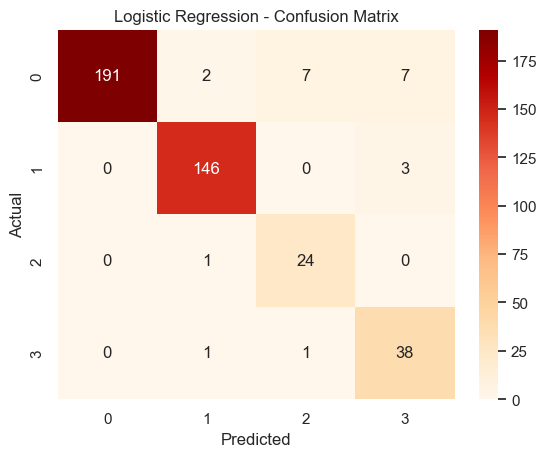

In [54]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='OrRd')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
logreg_results = {
    'Model': 'Logistic Regression',
#     'C': best_C,
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr,average="macro"),
    'Precision': precision_score(y_test, y_pred_lr,average="macro"),
    'Recall': recall_score(y_test, y_pred_lr,average="macro"),
}
results_df = pd.concat([results_df, pd.DataFrame([logreg_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143


## 7.4 — Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *

# Define the parameter grid
param_dist = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

# Initialize the base model
dt = DecisionTreeClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(dt, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='f1',
                                   random_state=42, n_jobs=-1, verbose=1)

random_search.fit(X_train_res, y_train_res)

# Best parameters
# Train the final model with best parameters
best_params_dt = random_search.best_params_
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 10, 'criterion': 'gini'}


In [58]:
dt_final = DecisionTreeClassifier(**best_params_dt, random_state=42)
dt_final.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=6, min_samples_split=5,
                       random_state=42)

In [59]:
y_pred_dt_final = dt_final.predict(X_test)
y_proba_dt_final = dt_final.predict_proba(X_test)[:, 1]

In [60]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt_final))
print("F1 Score:", f1_score(y_test, y_pred_dt_final,average="macro"))
print("Precision:", precision_score(y_test, y_pred_dt_final,average="macro"))
print("Recall:", recall_score(y_test, y_pred_dt_final,average="macro"))

Accuracy: 0.9691211401425178
F1 Score: 0.956862482714842
Precision: 0.950466743920833
Recall: 0.9635422137924325


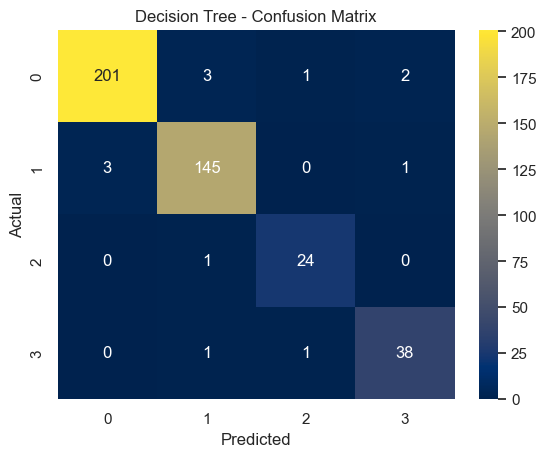

In [61]:
cm_dt = confusion_matrix(y_test, y_pred_dt_final)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='cividis')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [63]:
dt_results = {
    'Model': 'Decision Tree',
#     'Best Params': best_params_dt,
    'Accuracy': accuracy_score(y_test, y_pred_dt_final),
    'F1 Score': f1_score(y_test, y_pred_dt_final,average="macro"),
    'Precision': precision_score(y_test, y_pred_dt_final,average="macro"),
    'Recall': recall_score(y_test, y_pred_dt_final,average="macro"),
}
results_df = pd.concat([results_df, pd.DataFrame([dt_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143
3,Decision Tree,0.969121,0.956862,0.950467,0.963542


## 7.5 — Random Forest

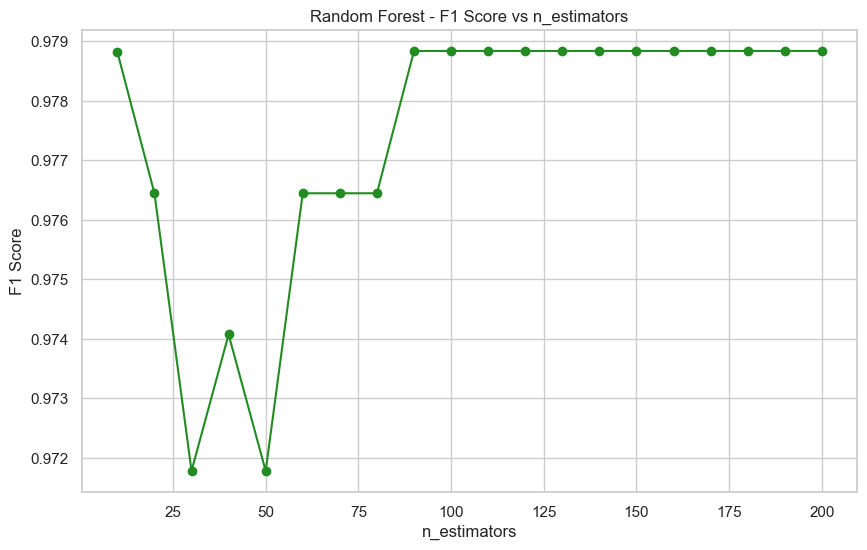

Best number of estimators: 90


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

estimators_range = list(range(10, 201, 10))
f1_scores_rf = []

for n in estimators_range:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train_res, y_train_res)
    y_pred_rf = rf_model.predict(X_test)
    f1_scores_rf.append(f1_score(y_test, y_pred_rf, average='weighted'))  # <-- FIXED

# Plot
plt.figure(figsize=(10,6))
plt.plot(estimators_range, f1_scores_rf, marker='o', color='forestgreen')
plt.title("Random Forest - F1 Score vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# Best n_estimators
best_n = estimators_range[np.argmax(f1_scores_rf)]
print(f"Best number of estimators: {best_n}")

In [66]:
rf_final = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf_final.fit(X_train_res, y_train_res)

y_pred_rf_final = rf_final.predict(X_test)
y_proba_rf_final = rf_final.predict_proba(X_test)[:, 1]

In [67]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf_final))
print("F1 Score:", f1_score(y_test, y_pred_rf_final,average="macro"))
print("Precision:", precision_score(y_test, y_pred_rf_final,average="macro"))
print("Recall:", recall_score(y_test, y_pred_rf_final,average="macro"))

Accuracy: 0.9786223277909739
F1 Score: 0.9603818083232967
Precision: 0.9519597069597069
Recall: 0.9693133774276173


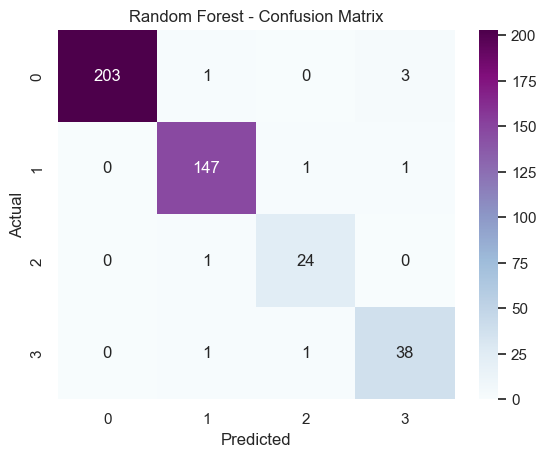

In [68]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_final)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='BuPu')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [70]:
rf_results = {
    'Model': 'Random Forest',
#     'n_estimators': best_n,
    'Accuracy': accuracy_score(y_test, y_pred_rf_final),
    'F1 Score': f1_score(y_test, y_pred_rf_final,average="macro"),
    'Precision': precision_score(y_test, y_pred_rf_final,average="macro"),
    'Recall': recall_score(y_test, y_pred_rf_final,average="macro"),
}
results_df = pd.concat([results_df, pd.DataFrame([rf_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143
3,Decision Tree,0.969121,0.956862,0.950467,0.963542
4,Random Forest,0.978622,0.960382,0.951960,0.969313


## 7.6 — XGBoost

Estimators: 50, F1 Score: 0.976
Estimators: 100, F1 Score: 0.976
Estimators: 150, F1 Score: 0.976
Estimators: 200, F1 Score: 0.976
Estimators: 250, F1 Score: 0.976
Estimators: 300, F1 Score: 0.974


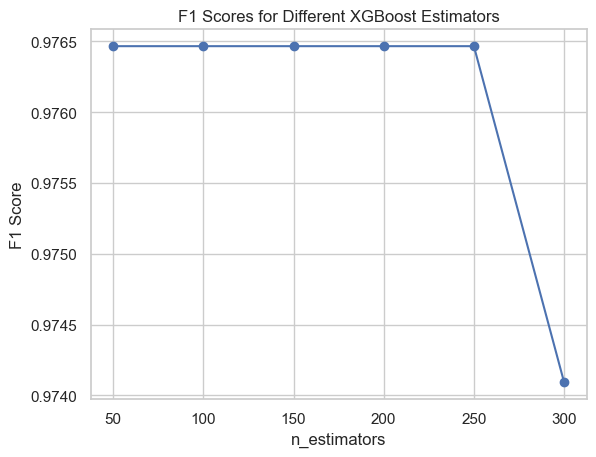

Best number of estimators: 50


In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

estimators = range(50, 301, 50)
f1_scores_xgb = []

for n in estimators:
    xgb = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_res, y_train_res)
    y_pred = xgb.predict(X_test)
    f1_scores_xgb.append(f1_score(y_test, y_pred, average='weighted'))  # <-- FIXED

# Print scores
for i, n in enumerate(estimators):
    print(f"Estimators: {n}, F1 Score: {f1_scores_xgb[i]:.3f}")

# Plot
plt.plot(estimators, f1_scores_xgb, marker='o')
plt.title('F1 Scores for Different XGBoost Estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Best n_estimators
best_n_xgb = estimators[np.argmax(f1_scores_xgb)]  # <-- FIXED
print(f"Best number of estimators: {best_n_xgb}")

In [73]:
xgb_final = XGBClassifier(n_estimators=best_n_xgb, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_final.fit(X_train_res, y_train_res)

y_pred_xgb_final = xgb_final.predict(X_test)
y_proba_xgb_final = xgb_final.predict_proba(X_test)[:, 1]

In [74]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_final))
print("F1 Score:", f1_score(y_test, y_pred_xgb_final,average="macro"))
print("Precision:", precision_score(y_test, y_pred_xgb_final,average="macro"))
print("Recall:", recall_score(y_test, y_pred_xgb_final,average="macro"))

Accuracy: 0.9762470308788599
F1 Score: 0.9589452000014032
Precision: 0.9503371904034156
Recall: 0.9681056479590182


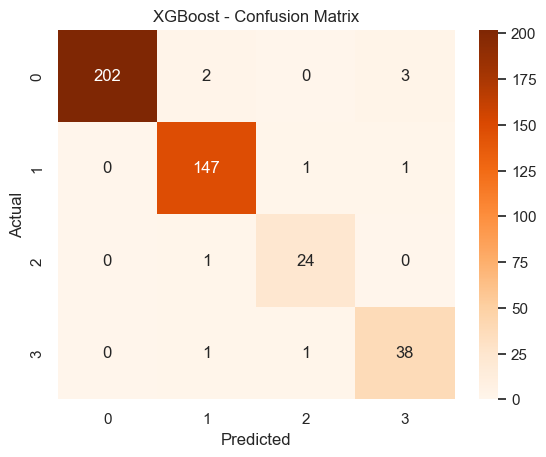

In [75]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb_final)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [76]:
xgb_results = {
    'Model': 'XGBoost',
#     'n_estimators': best_n_xgb,
    'Accuracy': accuracy_score(y_test, y_pred_xgb_final),
    'F1 Score': f1_score(y_test, y_pred_xgb_final,average="macro"),
    'Precision': precision_score(y_test, y_pred_xgb_final,average="macro"),
    'Recall': recall_score(y_test, y_pred_xgb_final,average="macro"),
}
results_df = pd.concat([results_df, pd.DataFrame([xgb_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143
3,Decision Tree,0.969121,0.956862,0.950467,0.963542
4,Random Forest,0.978622,0.960382,0.951960,0.969313
5,XGBoost,0.976247,0.958945,0.950337,0.968106


## 7.7 — LightGBM

In [77]:
lgbm = lgb.LGBMClassifier(random_state=42)

param_dist = {
    'n_estimators': list(range(50, 300, 50)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 50],
    'max_depth': [3, 5, 7, -1]
}

In [78]:
random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist,
    n_iter=20, scoring='f1', cv=5,
    random_state=42, n_jobs=-1, verbose=1
)

random_search.fit(X_train_res, y_train_res)

best_lgbm = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 3308, number of used features: 4
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Params: {'num_leaves': 15, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}


In [79]:
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

In [80]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm,average="macro"))
print("Precision:", precision_score(y_test, y_pred_lgbm,average="macro"))
print("Recall:", recall_score(y_test, y_pred_lgbm,average="macro"))

Accuracy: 0.9738717339667459
F1 Score: 0.9530329833271618
Precision: 0.9487178947532524
Recall: 0.9576355250786239


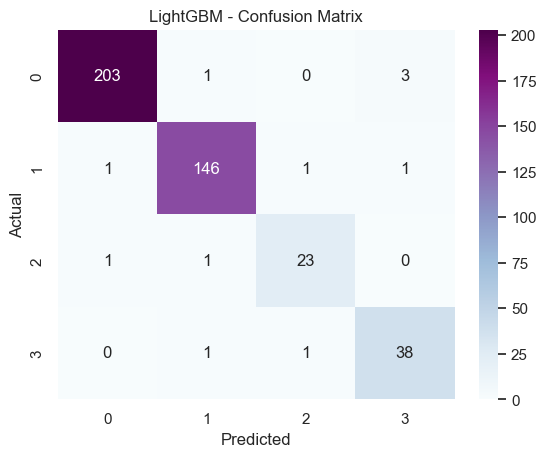

In [81]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='BuPu')
plt.title("LightGBM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [82]:
lgbm_results = {
    'Model': 'LightGBM',
#     'Best Params': random_search.best_params_,
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'F1 Score': f1_score(y_test, y_pred_lgbm,average="macro"),
    'Precision': precision_score(y_test, y_pred_lgbm,average="macro"),
    'Recall': recall_score(y_test, y_pred_lgbm,average="macro"),
}

results_df = pd.concat([results_df, pd.DataFrame([lgbm_results])], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143
3,Decision Tree,0.969121,0.956862,0.950467,0.963542
4,Random Forest,0.978622,0.960382,0.951960,0.969313
5,XGBoost,0.976247,0.958945,0.950337,0.968106
6,LightGBM,0.973872,0.953033,0.948718,0.957636


## 7.8 — Comparison

In [83]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,KNN,0.992874,0.986565,0.982457,0.990864
1,SVM,0.976247,0.965105,0.954648,0.976428
2,Logistic Regression,0.947743,0.910532,0.878750,0.953143
3,Decision Tree,0.969121,0.956862,0.950467,0.963542
4,Random Forest,0.978622,0.960382,0.951960,0.969313
5,XGBoost,0.976247,0.958945,0.950337,0.968106
6,LightGBM,0.973872,0.953033,0.948718,0.957636


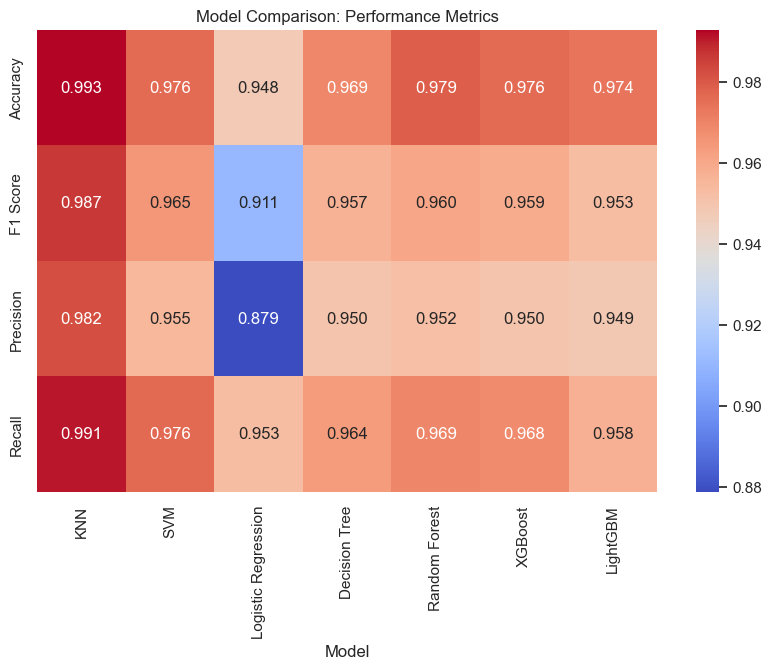

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with your model results
results = results_df.copy()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize the metrics
sns.heatmap(results.drop('Model', axis=1).set_index(results['Model']).T, annot=True, cmap='coolwarm', fmt='.3f')

# Add title
plt.title('Model Comparison: Performance Metrics')

# Display the plot
plt.show()

### 🎉 End of Notebook

You have:
- Performed comprehensive data visualization 
- Conducted data preparation (cleaning, feature engineering, encoding, scaling)  
- Selected the most relevant features 
- Handled class imbalance using SMOTE  
- Built and evaluated multiple machine learning models
- Compared model performances to identify the best one  